#  GeoPandas and spatial joins
------------

## Introduction

### Overview

This notebook is a re-implementation of the chapter in the book *Python Maps*, relating to road networks.  Being a chauvanistic Australian, I used the Australian road network to re-imagine some of the  maps from the book 

In a previous post, I generated a map showing Queensland roads only, with the dismissive comment:

>My first thought was to use the spatial join `intersects` predicate, but this took longer than my patience would allow, ...

Then I thought that I really needed to understand the performance issues of GeoPandas spatial joins a little better.  This post documents my explorations:  I especially used information from [https://geoffboeing.com/2016/10/r-tree-spatial-index-python/]

### Data Source
The main source of data used comes from [https://www.globio.info/download-grip-dataset]

>GRIP global roads database
>
>The Global Roads Inventory Project (GRIP) dataset was developed to provide a more recent and consistent global roads dataset for use in global environmental and biodiversity assessment models like GLOBIO.

--------------
## Implementation

### Notebook magic commands

`watermark` provides reproducibility data, `lab_black` enforces a standard Python style

In [62]:
%matplotlib inline

In [63]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [64]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


### Notebook imports

In [65]:
# all imports should go here

import pandas as pd

import geopandas as gpd
import geodatasets as gds

from shapely.geometry import Point

import cartopy.crs as ccrs


import matplotlib.pyplot as plt

--------------------------------------

## Processing subset of data in Parquet format

### Data load and quick mapping

We read Parquet file.  It is noticably quicker than reading the raw Shapefile.

In [66]:
PARQ_URL = 'C:\\Data\\PythonMaps\\Roads\\roads.parquet'

r = gpd.read_parquet(PARQ_URL)
r.head(3)

# set up spatial index
r.sindex

We check how big the data set is - not small!

In [67]:
r.shape

(289898, 11)

We re-plot the data set read from the Parquet file, and get the same map as from the Shapefile (as expected)

<Axes: >

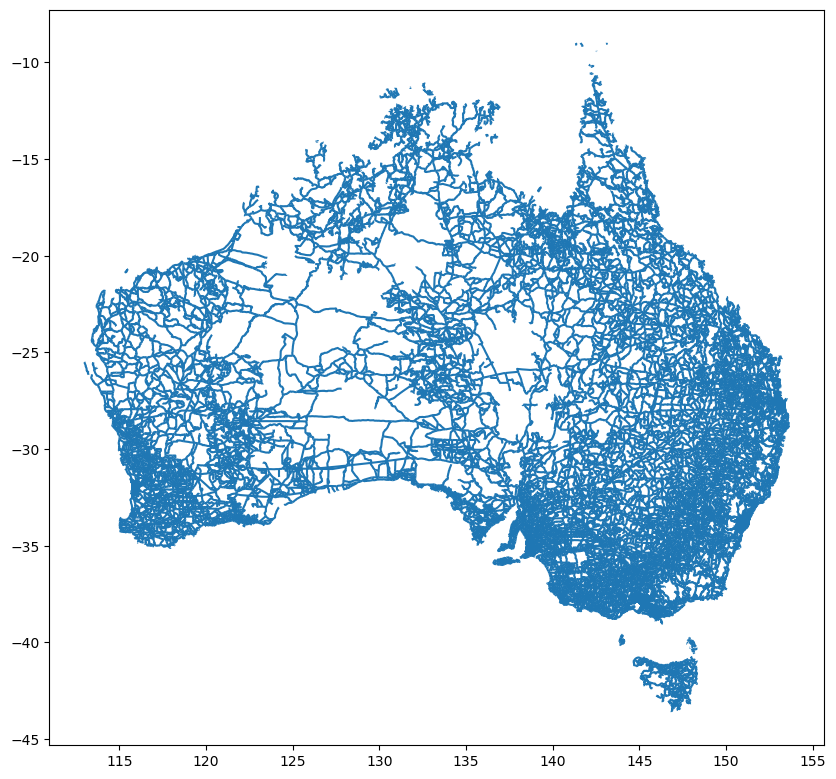

In [68]:
fig, ax = plt.subplots(figsize=(10, 10))

r.plot(ax=ax)

### De-cluttering map

In order to de-clutter the maps I will draw below, I chose different linewidths for each type of road (in a dict), and construct an array that maps a linewidth to each road segment.  I will also ask for a legend, and set the legend text manually to a more meaning name that the road-type code number.  I use Jet as my colormap, and tie it to the Road Type from the original dataset.

In [69]:
road_width = {1: 2, 2: 1, 3: 0.5, 4: 0.25, 5: 0.1}

---------------------
## Masking with maps

### Data load
The one thing that is missing from the map above is a coastline.  So I decided to supply a coastline, and zoom into Queensland (my home state)

The Australia Bureau of Statistics provides Digital boundary files, with latest being Australian Statistical Geography Standard (ASGS) Edition 3 [https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files]

I am in luck, there is a single MULTIPOLYGON that covers Queensland!

In [70]:
oz_url = "C:\\Data\\PythonMaps\\Oz_Borders\\STE_2021_AUST_GDA2020.shp"

In [71]:
oz = gpd.read_file(oz_url)

oz.head()

STE_CODE21         STE_NAME21 CHG_FLAG21  CHG_LBL21 AUS_CODE21 AUS_NAME21  \
0          1    New South Wales          0  No change        AUS  Australia   
1          2           Victoria          0  No change        AUS  Australia   
2          3         Queensland          0  No change        AUS  Australia   
3          4    South Australia          0  No change        AUS  Australia   
4          5  Western Australia          0  No change        AUS  Australia   

     AREASQKM21                                       LOCI_URI21  \
0  8.007977e+05  http://linked.data.gov.au/dataset/asgsed3/STE/1   
1  2.274962e+05  http://linked.data.gov.au/dataset/asgsed3/STE/2   
2  1.730171e+06  http://linked.data.gov.au/dataset/asgsed3/STE/3   
3  9.842314e+05  http://linked.data.gov.au/dataset/asgsed3/STE/4   
4  2.526632e+06  http://linked.data.gov.au/dataset/asgsed3/STE/5   

                                            geometry  
0  MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ...  
1  MULTIPOLYGON (((146.29286 -39.15778, 146.29341...  
2  MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ...  
3  MULTIPOLYGON (((140.66025 -38.06256, 140.66006...  
4  MULTIPOLYGON (((117.86953 -35.19108, 117.86961...

Do a quick and easy plot to make certain we have Queensland.  Looks OK, but note all the little islands.

<Axes: >

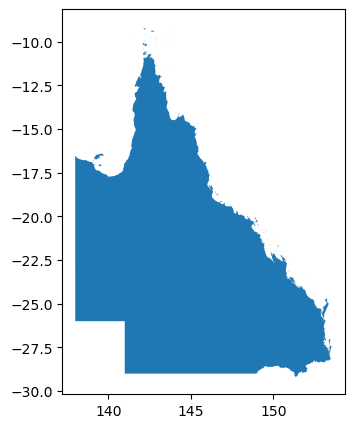

In [72]:
fig, ax = plt.subplots(
    figsize=(5, 5),
)

oz[oz['STE_NAME21'] == 'Queensland'].plot(ax=ax)

### Getting projections right
We have one slight problem, the projections used in our two datasets (Roads data, and Queensland coastline) are different.  Australia tends to have country-specific Datums, not the least because the continental plate we sit upon is moving north at a fair clip.

#### Roads dataset projection

In [73]:
r.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Queensland dataset projection

In [74]:
oz.crs

<Geographic 2D CRS: EPSG:7844>
Name: GDA2020
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore.
- bounds: (93.41, -60.55, 173.34, -8.47)
Datum: Geocentric Datum of Australia 2020
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Therefore, we convert the Queensland dataset to the projection the Roads dataset uses.

In [75]:
qld = (
    oz[oz['STE_NAME21'] == 'Queensland']
    .to_crs(r.crs)
    .copy()
)

It turns out that GeoDataFrames don't get a spatial index by default, so we create one for our Queensland GeoDataFrame

In [76]:
qld.has_sindex

False

In [77]:
qld.sindex

In [78]:
qld.has_sindex

True

----------------
### Getting a handle on sizes

We already have seen we have about 300,000 road segments in our roads GeopDataFrame.  Now I `explode` the Queensland Multiploygon to see how many polygons we have

In [79]:
qld.explode().head(2)

STE_CODE21  STE_NAME21 CHG_FLAG21  CHG_LBL21 AUS_CODE21 AUS_NAME21  \
2          3  Queensland          0  No change        AUS  Australia   
2          3  Queensland          0  No change        AUS  Australia   

     AREASQKM21                                       LOCI_URI21  \
2  1.730171e+06  http://linked.data.gov.au/dataset/asgsed3/STE/3   
2  1.730171e+06  http://linked.data.gov.au/dataset/asgsed3/STE/3   

                                            geometry  
2  POLYGON ((142.5314 -10.68301, 142.53072 -10.68...  
2  POLYGON ((142.66893 -10.667, 142.66882 -10.666...

In [80]:
qld.explode().shape

(1136, 9)

So we have over 1,000 polygons that define the state of Queensland.  We now do a timed spatial join to get the roads `contained` in the Queensland MultiPolygon


--------------
### Initial spatial join with `contains`

We time a spatial join, ask for all roads that are **within** in Queensland.  This was my first attemp at selecting Queensland roads.  Note that this not what I really wanted, as roads that span the Queensland border will not appear (including roads that appear to cross the coastline - the perils of using geographic datasets from different entities, probably using different precision in their mapping)

We find it takes about 0.5 seconds.

In [81]:
%timeit -n1 -r1 qld_roads = gpd.sjoin(r,qld, predicate='within', )

425 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Let us plot the results of the `within` spatial join

In [82]:
qld_roads = gpd.sjoin(
    r,
    qld,
    predicate='within',
)

Set up road widths

In [83]:
qld_road_widths = [
    road_width[i] for i in qld_roads['GP_RTP']
]

Map the results

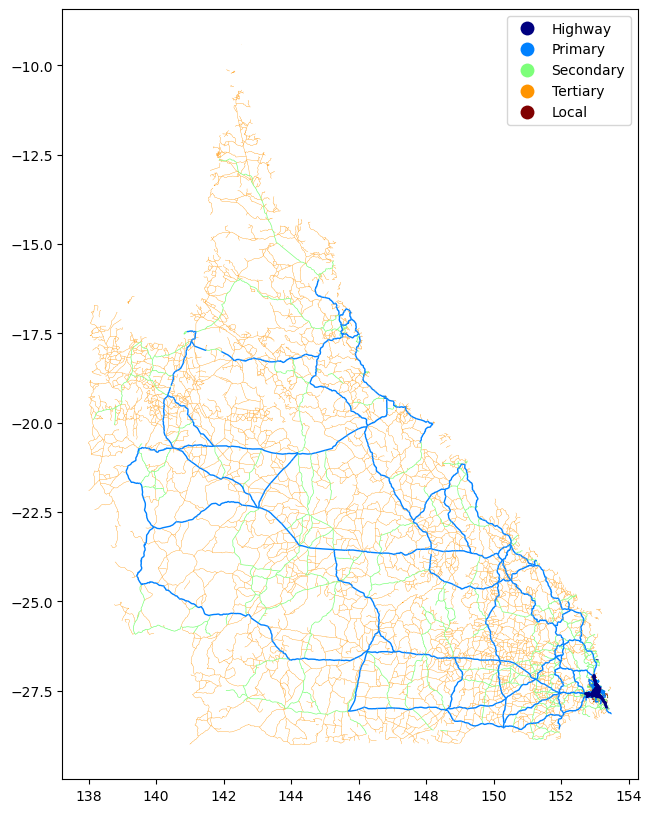

In [84]:
fig, axs = plt.subplots(
    figsize=(10, 10),
)

ax = axs
qld_roads.plot(
    ax=ax,
    column='GP_RTP',
    categorical=True,
    cmap='jet',
    legend=True,
    lw=qld_road_widths,
)

leg1 = ax.get_legend()
leg1.get_texts()[0].set_text('Highway')
leg1.get_texts()[1].set_text('Primary')
leg1.get_texts()[2].set_text('Secondary')
leg1.get_texts()[3].set_text('Tertiary')
leg1.get_texts()[4].set_text('Local')

plt.show()

## Fail!!

And this is when I discovered a big chunk of Primary road missing, at about 21S, 149E!!  The road segment goes outside the masking coastline polygon 

-----------------------

### Spatial joins with `intersects`
In my previous post, I tried the `intersects` spatial join predicate, but got impatient and used buffering to fix the missing road.  In this post, I will examine  how the `intersects` spatial join can be improved.

>%timeit -n1 -r1 qld_roads = gpd.sjoin(r,qld, predicate='intersects', )
>
>32min 21s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
>
> A second run
>
>37min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

So a naive `intersection` spatial join takes about 30 minutes! 


Check we have a spatial index defined for both GeoDataFrames

In [85]:
r.has_sindex, qld.has_sindex

(True, True)

It looks like each GeoDataFrame has a spatial index defined.



### Re-examine requirements
A little pondering, and I realise that I only want small graphics, and any roads that are contained on the Queensland islands won't be very visible. So I decided to filter out small islands, keeping only the mainland

We first `explode` the geometry to get multiple rows, one for each polygon that makes up Queensland.  Then we define a new column (`area`) that contains the area of each polygon.  Listing the areas, sorted by area,  shows we have one large polygon (the mainland) and very much smaller polygons.

We can ignore the warning about using Latitude and Longitude to compute area, as we only wanted a rough comparison between polygons.  If accuracy really mattered, we would get the best UTM Coordinated Reference System to use, as shown below.

In [86]:
qld2 = qld.explode()
qld2['area'] = qld2.area
qld2.nlargest(5, 'area')['area']

C:\Users\donrc\AppData\Local\Temp\ipykernel_1464\3750986347.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  qld2['area'] = qld2.area


2    151.728416
2      0.148655
2      0.085005
2      0.051179
2      0.033994
Name: area, dtype: float64

In [87]:
# we would convert to this CRS if area accuracy mattered
qld.estimate_utm_crs()

<Projected CRS: EPSG:32755>
Name: WGS 84 / UTM zone 55S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 144°E and 150°E, southern hemisphere between 80°S and equator, onshore and offshore. Australia. Papua New Guinea.
- bounds: (144.0, -80.0, 150.0, 0.0)
Coordinate Operation:
- name: UTM zone 55S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

-------------

### Visual check
We do a quick plot to check we have the mainland, i.e. the largest polygon - (on shakey ground comparing floats for equality, but assignment should not lose precision)

<Axes: >

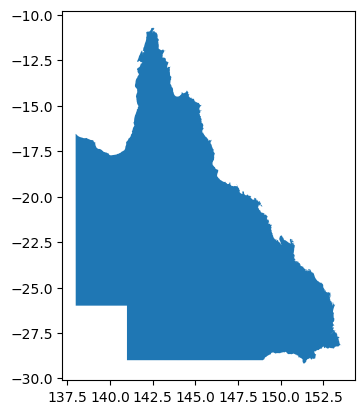

In [88]:
area_max = qld2['area'].max()

qld3 = qld2[qld2['area'] >= area_max].copy()
qld3.plot()

A second check shows the discarded polygons are indeed just minor islands

<Axes: >

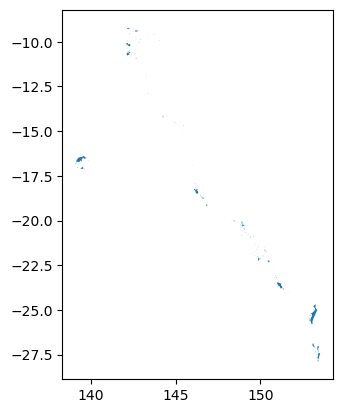

In [89]:
qld2[qld2['area'] < area_max].plot()

----------------------
### Filtering out non-Qld roads
We can use the GeoPandas spatial join predicate `intersects` to get all the roads that lie within Queensland (either wholly or partially), but even that query is slow (but much faster than the naive spatial join, as shown above)

> %timeit -n1 -r1 qld_roads = gpd.sjoin(r,qld3, predicate='intersects', )

>6min 47s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
> 

Let us see if we can do better.  Check if we have a spatial index for our  Queensland GeoDataFrame.


In [90]:
qld3.sindex
qld3.has_sindex

True

### Get mainland Queensland polygon

In [91]:
qld3.head()

STE_CODE21  STE_NAME21 CHG_FLAG21  CHG_LBL21 AUS_CODE21 AUS_NAME21  \
2          3  Queensland          0  No change        AUS  Australia   

     AREASQKM21                                       LOCI_URI21  \
2  1.730171e+06  http://linked.data.gov.au/dataset/asgsed3/STE/3   

                                            geometry        area  
2  POLYGON ((152.93631 -25.74358, 152.9363 -25.74...  151.728416

Show the polygon for mainland Queensland (Shapely will plot geometry primitives).  We reset the index to be able to address by [0]

In [92]:
qld3.reset_index().loc[0]['geometry']

In [93]:
qld_polygon = qld3.reset_index().loc[0]['geometry']
len(qld_polygon.boundary.xy[0])

120807

-----------------------
## Using spatial indices
### Get all candidates for roads that might be in Queensland


Get the spatial index of the GeoDataFrame holding all Australian roads

In [94]:
r_spatial_index = r.sindex
r.has_sindex

True

Get the indices of the roads that intersect the Queensland polygon bounding box  (this is very fast)

In [95]:
%timeit -n1 -r1 possible_matches_index = list(r_spatial_index.intersection(qld_polygon.bounds))

4.59 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [96]:
possible_matches_index = list(
    r_spatial_index.intersection(qld_polygon.bounds)
)

In [97]:
len(possible_matches_index)

55057

Plot the possible candidate roads.  Note that the bounding box includes a chunk of New South Wales, south of the Darling River section of the Queensland border (in lower south-east), so we know some of these candidate roads are very likely to be filtered out, as are some of the ones in the south west corner.

<Axes: >

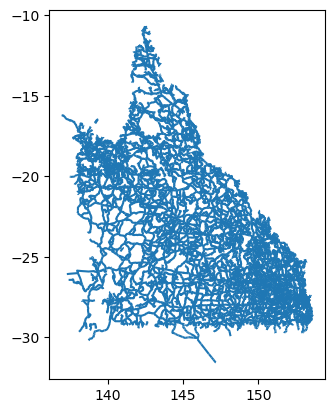

In [98]:
possible_matches = r.iloc[possible_matches_index]
possible_matches.plot()

------------------------

## Get all roads completely with Queensland

Refine the intersecting polygon to the actual Queensland polygon (not just bounding box)

Find indices of all roads contained within the Qld polygon: again, pretty fast.

In [99]:
%timeit -n1 -r1 within_index = list(r_spatial_index.query(qld_polygon, predicate='contains',))

273 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


`within_index`  are the indices (into the `r` GeoDataFrame) of the road segments that are contained entirely within the Queensland mainland polygon.

In [100]:
within_index = list(
    r_spatial_index.query(
        qld_polygon,
        predicate='contains',
    )
)

`contained_road`  is the GeoDataFrame holding roads contained entirely within the Queensland mainland polygon.  The plot clearly shows the Darling River border section 

<Axes: >

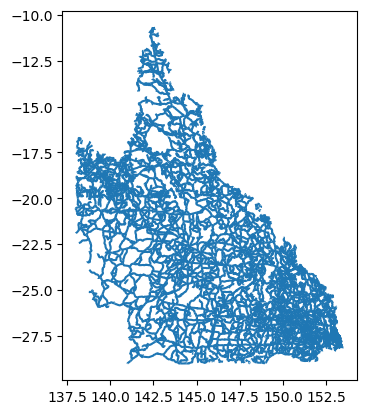

In [101]:
contained_road = r.iloc[within_index].copy()

contained_road.plot()

We have about 55,000 road segments that could be Queensland roads (in whole or part), and about 54,000 that we know are definitely completely within Queensland 

In [102]:
len(possible_matches_index), len(within_index),

(55057, 53922)

--------------------------

### Get roads that cross the border

Get indices of roads (into the `r` GeoDataFrame) that either completely outside or crossing the Queensland border.  We map these roads to confirm they are associated with the Queensland border

In [103]:
border_index = list(
    set(possible_matches_index) - set(within_index)
)

<Axes: >

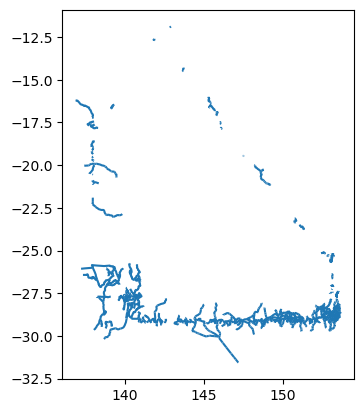

In [104]:
border_road = r.iloc[border_index].copy()

border_road.plot()

Create and check the spatial index for the border-crossing candidates

In [105]:
border_road.sindex
print(border_road.has_sindex)
border_sindex = border_road.sindex

True


Get indices of roads segments (into the r GeoDataFrame) that intersect the Queensland mainland polygon.  Note that we are **not** doing an `intersects` operation on the roughly 300,000 road segments in our original dataset, but only the roughly 1,000 possible candidates left after excluding the "completely inside" road segments from our bounding box candidates. This is very fast.

In [106]:
%timeit -n1 -r1 crossing_index = list(border_sindex.query(qld_polygon, predicate='intersects'))

36 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [107]:
crossing_index = list(
    border_sindex.query(qld_polygon, predicate='intersects')
)

We get about 100 road segments that cross the Queensland mainland border

In [108]:
len(within_index), len(possible_matches_index), len(
    border_index
), len(crossing_index)

(53922, 55057, 1135, 118)

Do a quick plot check, first showing the border crossing roads, then all the roads

<Axes: >

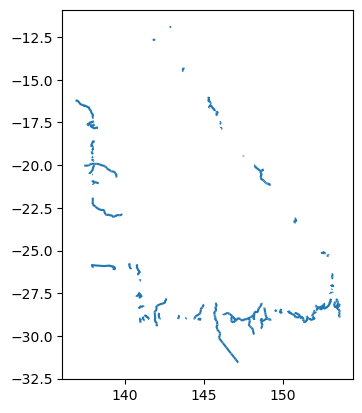

In [109]:
crossing_road = border_road.iloc[crossing_index].copy()

crossing_road.plot()

<Axes: >

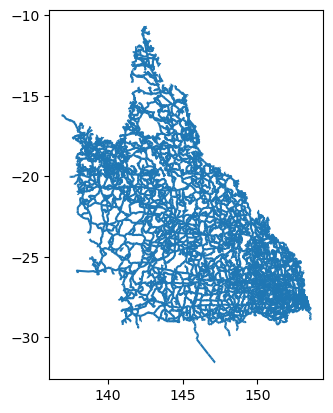

In [110]:
ax = contained_road.plot()
crossing_road.plot(
    ax=ax,
)

----------------------
## Visualize final selection

Set up plotted line widths based upon road type

In [111]:
contained_road_widths = [
    road_width[i] for i in contained_road['GP_RTP']
]

crossing_road_widths = [
    road_width[i] for i in crossing_road['GP_RTP']
]

Regenerate coast line in the same CRS as the roads GeoDataFrames

In [112]:
qld_coast = (
    oz[oz['STE_NAME21'] == 'Queensland']
    .to_crs(r.crs)
    .copy()
)

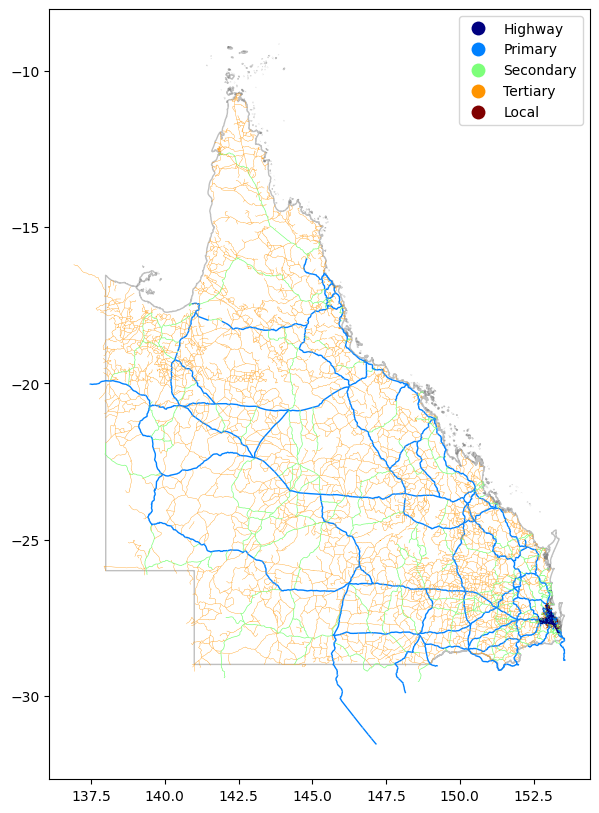

In [113]:
fig, axs = plt.subplots(
    figsize=(10, 10),
)

ax = axs
contained_road.copy().plot(
    ax=ax,
    column='GP_RTP',
    categorical=True,
    cmap='jet',
    legend=True,
    lw=contained_road_widths,
)

crossing_road.copy().plot(
    ax=ax,
    column='GP_RTP',
    categorical=True,
    cmap='jet',
    legend=True,
    lw=crossing_road_widths,
)

qld_coast.plot(
    ax=ax,
    facecolor='none',
    edgecolor='gray',
    alpha=0.5,
)

leg1 = ax.get_legend()
leg1.get_texts()[0].set_text('Highway')
leg1.get_texts()[1].set_text('Primary')
leg1.get_texts()[2].set_text('Secondary')
leg1.get_texts()[3].set_text('Tertiary')
leg1.get_texts()[4].set_text('Local')

plt.show()

## Success!!

We get back our Primary road at 21S, 149E 

-------------------------
 
## Final Map
We tidy up the border roads, clipping them to inside the border

In [114]:
%timeit -n1 -r1  clipped_crossing = gpd.clip(crossing_road, qld_polygon)

1.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [115]:
clipped_crossing = gpd.clip(
    crossing_road.cx[:, :-25], qld_polygon
)

Quick plot chcek clip operation

<Axes: >

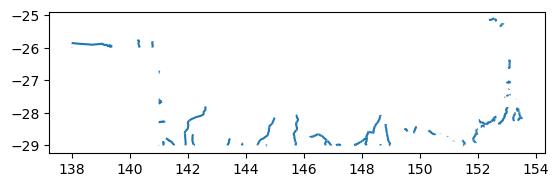

In [116]:
clipped_crossing.plot()

In [117]:
clipped_crossing_widths = [
    road_width[i] for i in clipped_crossing['GP_RTP']
]

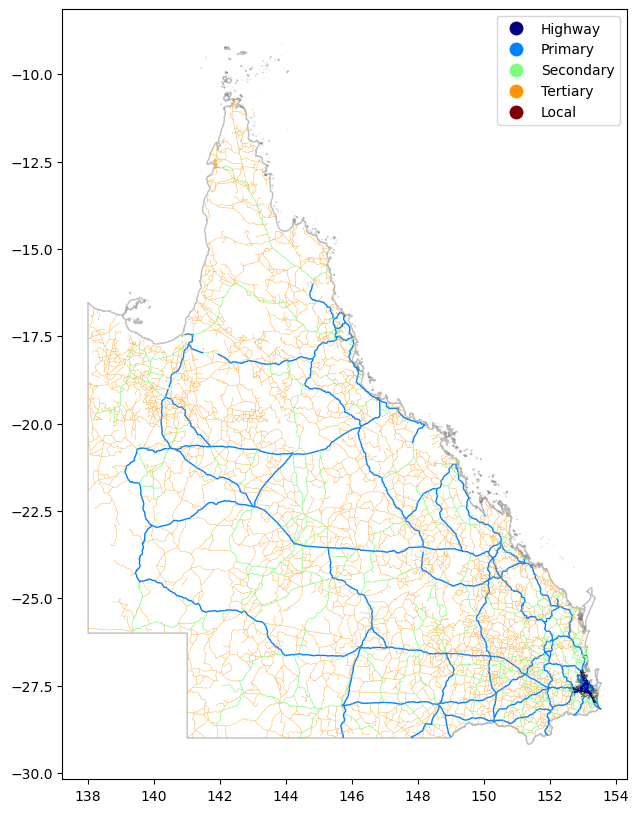

In [118]:
fig, axs = plt.subplots(
    figsize=(10, 10),
)

ax = axs
contained_road.copy().plot(
    ax=ax,
    column='GP_RTP',
    categorical=True,
    cmap='jet',
    legend=True,
    lw=contained_road_widths,
)

clipped_crossing.copy().plot(
    ax=ax,
    column='GP_RTP',
    categorical=True,
    cmap='jet',
    legend=True,
    lw=clipped_crossing_widths,
)

qld_coast.plot(
    ax=ax,
    facecolor='none',
    edgecolor='gray',
    alpha=0.5,
)

leg1 = ax.get_legend()
leg1.get_texts()[0].set_text('Highway')
leg1.get_texts()[1].set_text('Primary')
leg1.get_texts()[2].set_text('Secondary')
leg1.get_texts()[3].set_text('Tertiary')
leg1.get_texts()[4].set_text('Local')

plt.show()

## Conclusions / Summary

The main take-away is that spatial joins and spatial indices can't be used naively, but the dataset being queried must be winnowed down, using your knowledge of the problem.  Explicit use of spatial indices is the key.

In this case, using the Queensland mainland bounding box reduced the dataset being queried markedly, as the bounding box and the real polygon were very close in shape.  As [https://geoffboeing.com/2016/10/r-tree-spatial-index-python/] points out, in some cases, the bounding box can include large areas that are **not** part of the masking polygon, so the dataset is **not** much reduced in size

-------------------
## Reproducibility

### Notebook version status

In [119]:
%watermark

Last updated: 2025-05-02T20:06:58.334763+10:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit



In [120]:
%watermark -h -iv

Hostname: INSPIRON16

cartopy    : 0.24.1
geodatasets: 2024.8.0
matplotlib : 3.10.0
geopandas  : 1.0.1
pandas     : 2.2.3
shapely    : 2.0.6



In [121]:
%watermark -co

conda environment: pythonmaps

